# Intro a Qiskit

In [4]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

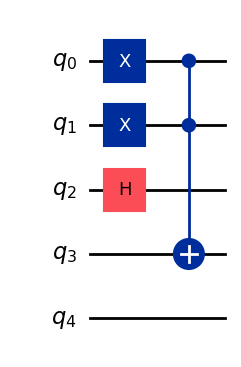

In [15]:
qc = QuantumCircuit(5)
qc.x(range(2))
qc.ccx(0, 1, target_qubit= 3)
qc.h(2)
qc.draw('mpl')



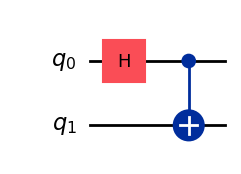

In [19]:
from qiskit.quantum_info import Statevector, DensityMatrix

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw('mpl')

In [20]:
DensityMatrix(qc).draw('latex')

<IPython.core.display.Latex object>